In [85]:
import requests
import os
import re
import json
import dataclasses as dc
import numpy as np
from dataclasses import field, asdict
from pprint import pprint
from shapely import wkt
from shapely.geometry import Polygon
from datetime import datetime, date, timezone
from pathlib import Path
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt

from shapely.ops import unary_union

## GLOBALS

In [3]:
CMR_URL = 'https://cmr.earthdata.nasa.gov/search/granules.json'



## Product Class

In [4]:
@dc.dataclass()
class Product:
    name: str
    shape: Polygon = None
    start: datetime = None
    end: datetime = None
        
    def __post_init__(self):
        self.product_time_regex = re.compile(
                r"S.*1SDV_(?P<start_year>\d{4})(?P<start_month>\d{2})(?P<start_day>\d{2})T(?P<start_hour>\d{2})("
                r"?P<start_minute>\d{2})(?P<start_second>\d{2})_(?P<end_year>\d{4})(?P<end_month>\d{2})(?P<end_day>\d{2})T("
                r"?P<end_hour>\d{2})(?P<end_minute>\d{2})(?P<end_second>\d{2})_*")
#         self.start = make_start(name)
#         self.end = make_end(name)
        self.start = self.make_start(self.name)
        self.end = self.make_end(self.name)
        
        

        
    def make_start(self,product_name) -> datetime:
        
        regex_match = re.match(self.product_time_regex, product_name)
        time_dict = regex_match.groupdict()
        for k, v in time_dict.items():
            time_dict[k] = int(v)

        return datetime(time_dict["start_year"], time_dict["start_month"], time_dict["start_day"],
                        time_dict["start_hour"], time_dict["start_minute"], time_dict["start_second"])



    def make_end(self, product_name) -> datetime:

        regex_match = re.match(self.product_time_regex, product_name)
        time_dict = regex_match.groupdict()
        for k, v in time_dict.items():
            time_dict[k] = int(v)

        return datetime(time_dict["end_year"], time_dict["end_month"], time_dict["end_day"],
                        time_dict["end_hour"], time_dict["end_minute"], time_dict["end_second"])
    
    
    def to_json(self):
        metadata = asdict(self)
        metadata['start'] = self.start.isoformat()
        metadata['end'] = self.end.isoformat()
        metadata['shape'] = str(self.shape)
        
#         for key in list(metadata):
#             if key is datetime:
#                 metadata[key] = metadata[key].isoformat()
#                 print(f"TEST: {key}= {metadata[key]}")
        return json.dumps(metadata)
        
        
    

### format_points

In [20]:
def format_points(point_string):
    converted_to_float = [float(x) for x in point_string.split(' ')]
    points = [list(t) for t in zip(converted_to_float[1::2], converted_to_float[::2])]
    return points

### Polygon_to_point_str

In [5]:

def polygon_to_point_str(poly: Polygon) -> str:
    """Input Polygon. Returns a CMR compatible point string """
    coord_lst = [coord for coord in list(poly.exterior.coords)]
    pt_lst = []
    for coord in coord_lst:
        for pt in coord:
            pt_lst.append(pt)
            
    listToStr = ','.join(map(str, pt_lst))
    return listToStr
    

#### TEST: polygon_to_point_str

In [8]:
# Test polygon_to_point_str
test_ptps_wkt = "POLYGON((-148.2421 63.9554,-146.4533 63.9554,-146.4533 64.9447,-148.2421 64.9447,-148.2421 63.9554))"
test_ptps_poly= wkt.loads(test_ptps_wkt)
test_ptps_point_str = "-148.2421,63.9554,-146.4533,63.9554,-146.4533,64.9447,-148.2421,64.9447,-148.2421,63.9554"


assert polygon_to_point_str(test_ptps_poly)==test_ptps_point_str
print(polygon_to_point_str(test_ptps_poly))

-148.2421,63.9554,-146.4533,63.9554,-146.4533,64.9447,-148.2421,64.9447,-148.2421,63.9554


### product_time

In [22]:
def product_time(product_name):
    product_time_regex = re.compile(
        r"S.*1SDV_(?P<start_year>\d{4})(?P<start_month>\d{2})(?P<start_day>\d{2})T(?P<start_hour>\d{2})("
        r"?P<start_minute>\d{2})(?P<start_second>\d{2})_(?P<end_year>\d{4})(?P<end_month>\d{2})(?P<end_day>\d{2})T("
        r"?P<end_hour>\d{2})(?P<end_minute>\d{2})(?P<end_second>\d{2})_*")

    regex_match = re.match(product_time_regex, product_name)
    time_dict = regex_match.groupdict()

    # converts all dates/times values in dictionary from int to string
    for k, v in time_dict.items():
        time_dict[k] = int(v)

    start = datetime(time_dict["start_year"], time_dict["start_month"], time_dict["start_day"],
                     time_dict["start_hour"], time_dict["start_minute"], time_dict["start_second"])

    end = datetime(time_dict["end_year"], time_dict["end_month"], time_dict["end_day"],
                   time_dict["end_hour"], time_dict["end_minute"], time_dict["end_second"])


    return start, end

### product_in_time_bounds

In [23]:
def product_in_time_bounds(product_name, start, end):
    prod_start, prod_end = product_time(product_name)
    
    return prod_start > start and prod_end < end
    

In [24]:
def format_time(time: datetime):
#     utc_time = time.astimezone(timezone.utc)
#     return utc_time.isoformat(timespec='seconds')
    return time.isoformat()

In [25]:
test_date = datetime(2020,8,1,0,0,0)
print(format_time(test_date))

2020-08-01T00:00:00


### get_cmr_metadata

In [26]:
def get_cmr_metadata(shape:Polygon, start: datetime, end: datetime):
    
    payload = {}
    payload['provider'] = 'ASF'
    payload['temporal'] = (start.isoformat(), end.isoformat())
    payload['polygon'] = polygon_to_point_str(shape)
    payload['short_name'] = (
            'SENTINEL-1A_DP_GRD_HIGH',
            'SENTINEL-1B_DP_GRD_HIGH',
            )
    payload['page_size'] = 100


    response = requests.post(CMR_URL, data=payload)
#     print(response.json)
    products = [
            entry['producer_granule_id'] for entry in response.json()['feed']['entry'] if product_in_time_bounds(entry['producer_granule_id'], start, end)
    ]
    return products
    granules = [
        {
            'name': entry['producer_granule_id'],
#             'polygon': Polygon(format_points(entry['polygons'][0][0]))
        } for entry in response.json()['feed']['entry']
    ]
    response.raise_for_status()
    return granules

## TEST: get_cmr_metadata

In [27]:
test_wkt   = "POLYGON((-148.1418 64.6321,-147.4753 64.6321,-147.4753 64.9466,-148.1418 64.9466,-148.1418 64.6321))"
test_poly  = wkt.loads(test_wkt)
test_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_end   = datetime(year=2020,month=8,day=8,hour=0,minute=0,second=0)

test_products = get_cmr_metadata(test_poly, test_start, test_end)

pprint(test_products)




['S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF',
 'S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8']


## get_products_cmr

In [28]:

# TODO: Get initial queary to return products of proper datetime
def get_products_cmr(shape:Polygon, start: datetime, end: datetime):
    
    payload = {}
    payload['provider'] = 'ASF'
    payload['temporal'] = (start.isoformat(), end.isoformat())
    payload['polygon'] = polygon_to_point_str(shape)
    payload['short_name'] = (
            'SENTINEL-1A_DP_GRD_HIGH',
            'SENTINEL-1B_DP_GRD_HIGH',
            )
    payload['page_size'] = 100

    response = requests.post(CMR_URL, data=payload)
#     pprint(response.json())

    products = []
    for entry in response.json()['feed']['entry']:
        if product_in_time_bounds(entry['producer_granule_id'], start, end):
            products.append(Product(
                                    name = entry['producer_granule_id'],
                                    shape = Polygon(format_points(entry['polygons'][0][0]))
                                   ))

    return products


### TEST: get_products_cmr

In [30]:
test_gpc_wkt   = "POLYGON((-148.1418 64.6321,-147.4753 64.6321,-147.4753 64.9466,-148.1418 64.9466,-148.1418 64.6321))"
test_gpc_poly  = wkt.loads(test_wkt)
test_gpc_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_gpc_end   = datetime(year=2020,month=8,day=15,hour=0,minute=0,second=0)

test_gpc_products = get_products_cmr(test_gpc_poly, test_gpc_start, test_gpc_end)


for product in test_gpc_products:
    print(product.to_json())
    



{"name": "S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF", "shape": "POLYGON ((-147.250381 64.64534, -146.353043 66.116508, -151.962357 66.58766199999999, -152.556412 65.101822, -147.250381 64.64534))", "start": "2020-08-07T16:28:18", "end": "2020-08-07T16:28:43"}
{"name": "S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8", "shape": "POLYGON ((-148.107025 63.174152, -147.250427 64.645256, -152.554779 65.101624, -153.141724 63.616859, -148.107025 63.174152))", "start": "2020-08-07T16:28:43", "end": "2020-08-07T16:29:08"}
{"name": "S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21", "shape": "POLYGON ((-143.374802 64.30976099999999, -142.475571 65.779594, -147.98317 66.24443100000001, -148.589005 64.759766, -143.374802 64.30976099999999))", "start": "2020-08-09T16:11:56", "end": "2020-08-09T16:12:21"}
{"name": "S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635", "shape": "POLYGON ((-144.179428 62.834026, -143.374

In [37]:
def tree(directory):
    """print directory tree of given Path object"""
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')

def create_directories(root_path: Path) -> None:
    """Creates the directories for storing our data"""
    
    PROJECT_ROOT = root_path.resolve().parents[1]
    
    # Path configurations for data directory
    DATA_DIR = PROJECT_ROOT / "data"

    GRANULES_DIR    = DATA_DIR / "granules"
    TILES_DIR       = DATA_DIR / "tiles"
    SHAPEFILE_DIR   = DATA_DIR / "shape_files"
    WATER_MASKS_DIR = DATA_DIR / "water_masks"
    
    
    directories = [GRANULES_DIR, SHAPEFILE_DIR, TILES_DIR, WATER_MASKS_DIR]
    for directory in directories:
        directory.mkdir(parents=True)

In [38]:
# with TemporaryDirectory() as tmpdir_name:
#     tmpdir_path = Path(tmpdir_name)
#     create_directories(tmpdir_path)
#     print(os.listdir(f"{str(tmpdir_path)}"))
    
    
with TemporaryDirectory() as tmpdir_name:
    
    tmpdir_path = Path(tmpdir_name)
    
    TILES_DIR       = tmpdir_path / "tiles/"
    GRANULES_DIR    = tmpdir_path / "granules"
    SHAPEFILE_DIR   = tmpdir_path / "shape_files"
    WATER_MASKS_DIR = tmpdir_path / "water_masks"
    
    directories = [GRANULES_DIR, SHAPEFILE_DIR, TILES_DIR, WATER_MASKS_DIR]
    for directory in directories:
        directory.mkdir(parents=True)
        
    print(f"Temp dirs created: {os.listdir(str(tmpdir_path))}")
    tree(tmpdir_path)
    
    

Temp dirs created: ['shape_files', 'granules', 'tiles', 'water_masks']
+ /tmp/tmpokp2aqj8
    + granules
    + shape_files
    + tiles
    + water_masks


In [39]:
def triage_products(products):
    return sorted(products, key=lambda product: product.start)

## RUN

S1B_IW_GRDH_1SDV_20200801T030347_20200801T030412_022724_02B20B_927C
S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437_022724_02B20B_0CBB
S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF
S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8
S1B_IW_GRDH_1SDV_20200809T033631_20200809T033656_022841_02B5B0_6CD7
S1B_IW_GRDH_1SDV_20200809T033656_20200809T033721_022841_02B5B0_147A
S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21
S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635
S1B_IW_GRDH_1SDV_20200811T032006_20200811T032031_022870_02B695_B919
S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8
S1B_IW_GRDH_1SDV_20200811T032056_20200811T032121_022870_02B695_27E2
S1B_IW_GRDH_1SDV_20200813T030348_20200813T030413_022899_02B76C_7220
S1B_IW_GRDH_1SDV_20200813T030413_20200813T030438_022899_02B76C_C6FA


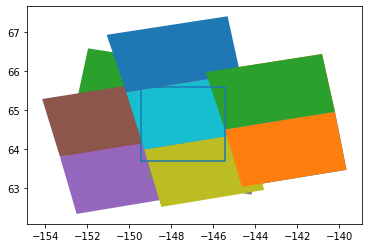

In [218]:
%matplotlib inline


test_aoi_wkt = "POLYGON((-149.4512 63.6973,-145.4227 63.6973,-145.4227 65.6,-149.4512 65.6,-149.4512 63.6973))"
test_aoi_poly  = wkt.loads(test_aoi_wkt)
test_aoi_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_aoi_end   = datetime(year=2020,month=8,day=15,hour=0,minute=0,second=0)

test_aoi_products = get_products_cmr(test_aoi_poly, test_aoi_start, test_aoi_end)


# for product in test_aoi_products:
#     print(product.name)
    
sorted_products = triage_products(test_aoi_products)


for product in sorted_products:
    print(product.name)

x,y = test_aoi_poly.exterior.xy
plt.plot(x,y)

for product in sorted_products:
    x,y = product.shape.exterior.xy
    plt.fill(x,y)

    
    
    
    
    
    
    
    
    
    
    

# with TemporaryDirectory() as tmpdir_aiwater:
    

    

In [305]:
       
from copy import copy, deepcopy

def percentage(part, whole):
  return 100 * float(part)/float(whole)

def get_min_granule_coverage(products: list, aoi: Polygon) -> list:
    """Input list of Product objects and a target Polygon.
       returns the minimum prodcuts needed to cover the AOI.
       Gives prefereance to the most recently created Products."""
    
    dif = copy(aoi)
    
    sorted_products = deepcopy(products)
    min_products = []
#     fill_shps = []
    
    for current in reversed(sorted_products):
        print(current.name)
        print(dif.area)
        
        if not round(percentage(dif.area, aoi.area)) > 0:
            return min_products
        
        current_shape = current.shape

        intersect = current_shape.intersection(aoi)
        
#         if dif.contains(intersect.buffer(-1e-14)):
#             continue
            
        min_products.insert(0, current)
        
        dif = dif - intersect
        
#         fill_shps.append(intersect)
        
#         if len(fill_shps) > 0:
#             fill = unary_union(fill_shps)
        


        

#     return min_products
    

In [306]:
%matplotlib inline

test_aoi_wkt = "POLYGON((-149.4512 63.6973,-145.4227 63.6973,-145.4227 65.6,-149.4512 65.6,-149.4512 63.6973))"
test_aoi_poly  = wkt.loads(test_aoi_wkt)
test_aoi_start = datetime(year=2020,month=8,day=1,hour=0,minute=0,second=0)
test_aoi_end   = datetime(year=2020,month=8,day=15,hour=0,minute=0,second=0)

test_aoi_products = get_products_cmr(test_aoi_poly, test_aoi_start, test_aoi_end)
test_sorted_aoi_products = triage_products(test_aoi_products)


test_min_products = get_min_granule_coverage(test_sorted_aoi_products, test_aoi_poly)


print(f"originally {len(test_aoi_products)}")
print(f"reduced to {len(test_min_products)}")

x,y = test_aoi_poly.exterior.xy
plt.plot(x,y)

for p in test_min_products:
    print(p.name)
    x,y = p.shape.exterior.xy
    plt.plot(x,y)

# assert len(test_min_product_names)==4

S1B_IW_GRDH_1SDV_20200813T030413_20200813T030438_022899_02B76C_C6FA
7.665026949999999
S1B_IW_GRDH_1SDV_20200813T030348_20200813T030413_022899_02B76C_7220
7.665026949999999
S1B_IW_GRDH_1SDV_20200811T032056_20200811T032121_022870_02B695_27E2
7.665026949999999
S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8
7.665026949999999
S1B_IW_GRDH_1SDV_20200811T032006_20200811T032031_022870_02B695_B919
7.665026949999999
S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635
7.665026949999999
S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21
7.665026949999999
S1B_IW_GRDH_1SDV_20200809T033656_20200809T033721_022841_02B5B0_147A
4.716015924853907
S1B_IW_GRDH_1SDV_20200809T033631_20200809T033656_022841_02B5B0_6CD7
3.3206611840157567
S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8
3.3206611840157567
S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF
1.9742469928232014
S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437_02

TypeError: object of type 'NoneType' has no len()

AssertionError: 

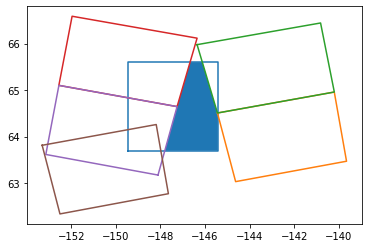

In [304]:
# test polygones from example products

t1 = Polygon([(-145.438751, 64.507965), (-144.623535, 63.03294), (-139.646072, 63.471382), (-140.196121, 64.958496), (-145.438751, 64.507965)])
t2 = Polygon([(-146.353333, 65.976906), (-145.438812, 64.508049), (-140.194275, 64.95871), (-140.811172, 66.442871), (-146.353333, 65.976906)])
t3 = Polygon([(-147.250381, 64.64534),  (-146.353043, 66.116508), (-151.962357, 66.58766199999999), (-152.556412, 65.101822), (-147.250381, 64.64534)])
t4 = Polygon([(-148.107025, 63.174152), (-147.250427, 64.645256), (-152.554779, 65.101624), (-153.141724, 63.616859), (-148.107025, 63.174152)])
t5 = Polygon([(-153.305618, 63.814056), (-152.50769, 62.338947), (-147.640671, 62.773293), (-148.187286, 64.26004), (-153.305618, 63.814056)])


# aoi poly
x,y = test_aoi_poly.exterior.xy
plt.plot(x,y)

# # t1
t1_inter = test_aoi_poly.intersection(t1)
x,y = t1.exterior.xy
plt.plot(x,y)
# x,y = t1_inter.exterior.xy
# plt.fill(x,y)

# # t2
t2_inter = test_aoi_poly.intersection(t2)
x,y = t2.exterior.xy
plt.plot(x,y)
# x,y = t2_inter.exterior.xy
# plt.fill(x,y)

# # t3
t3_inter = test_aoi_poly.intersection(t3)
x,y = t3.exterior.xy
plt.plot(x,y)
# x,y = t3_inter.exterior.xy
# plt.fill(x,y)

# # t4
t4_inter = test_aoi_poly.intersection(t4)
x,y = t4.exterior.xy
plt.plot(x,y)
# x,y = t4_inter.exterior.xy
# plt.fill(x,y)

# # t5
t5_inter = test_aoi_poly.intersection(t5)
x,y = t5.exterior.xy
plt.plot(x,y)
# x,y = t5_inter.exterior.xy
# plt.fill(x,y)

# union
# u = unary_union([t3_inter, t4_inter, t5_inter])
# x,y = u.exterior.xy
# plt.fill(x,y)


# difference from aoi
u = unary_union([t1_inter, t2_inter, t3_inter, t4_inter, t5_inter])
dif = test_aoi_poly - u
x,y = dif.exterior.xy
plt.fill(x,y)


assert dif.equals(test_aoi_poly)







# POLYGON ((-154.149109 65.28845200000001, -153.305679 63.814144, -148.185486 64.260254, -148.746719 65.74745900000001, -154.149109 65.28845200000001))
# POLYGON ((-143.374802 64.30976099999999, -142.475571 65.779594, -147.98317 66.24443100000001, -148.589005 64.759766, -143.374802 64.30976099999999))
# POLYGON ((-144.179428 62.834026, -143.374863 64.309669, -148.587158 64.759552, -149.130157 63.272141, -144.179428 62.834026))
# POLYGON ((-149.282196 63.992645, -148.47467 62.51812, -143.579681 62.95327, -144.132401 64.439751, -149.282196 63.992645))
# POLYGON ((-150.147675 65.465256, -149.282257 63.992733, -144.1306 64.439964, -144.709641 65.926163, -150.147675 65.465256))
# POLYGON ((-151.075882 66.93590500000001, -150.147736 65.46534699999999, -144.707932 65.92636899999999, -145.31337 67.412346, -151.075882 66.93590500000001))
# POLYGON ((-145.441833 64.507774, -144.626434 63.032768, -139.649048 63.471336, -140.199295 64.95843499999999, -145.441833 64.507774))
# POLYGON ((-146.356613 65.97669999999999, -145.441895 64.50786600000001, -140.197449 64.958656, -140.814545 66.44280999999999, -146.356613 65.97669999999999))

POLYGON ((-145.438751 64.507965, -144.623535 63.03294, -139.646072 63.471382, -140.196121 64.958496, -145.438751 64.507965))
POLYGON ((-146.353333 65.976906, -145.438812 64.508049, -140.194275 64.95871, -140.811172 66.442871, -146.353333 65.976906))
POLYGON ((-147.250381 64.64534, -146.353043 66.116508, -151.962357 66.58766199999999, -152.556412 65.101822, -147.250381 64.64534))
POLYGON ((-148.107025 63.174152, -147.250427 64.645256, -152.554779 65.101624, -153.141724 63.616859, -148.107025 63.174152))
POLYGON ((-153.305618 63.814056, -152.50769 62.338947, -147.640671 62.773293, -148.187286 64.26004, -153.305618 63.814056))
POLYGON ((-154.149109 65.28845200000001, -153.305679 63.814144, -148.185486 64.260254, -148.746719 65.74745900000001, -154.149109 65.28845200000001))
POLYGON ((-143.374802 64.30976099999999, -142.475571 65.779594, -147.98317 66.24443100000001, -148.589005 64.759766, -143.374802 64.30976099999999))
POLYGON ((-144.179428 62.834026, -143.374863 64.309669, -148.587158 6

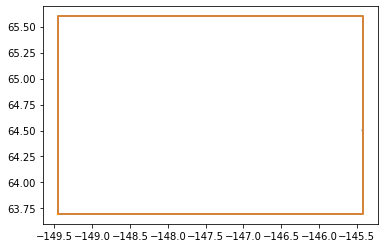

intersections aoi S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437_022724_02B20B_0CBB
total_fill type is <class 'shapely.geometry.multipolygon.MultiPolygon'>


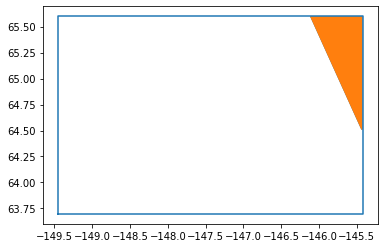

intersections aoi S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF
total_fill type is <class 'shapely.geometry.multipolygon.MultiPolygon'>


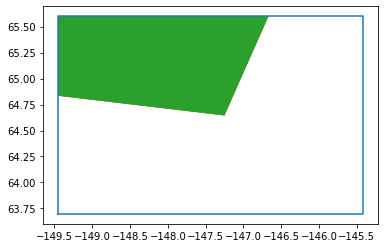

intersections aoi S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8
total_fill type is <class 'shapely.geometry.multipolygon.MultiPolygon'>


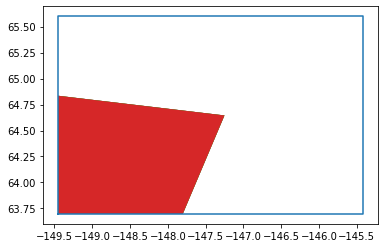

intersections aoi S1B_IW_GRDH_1SDV_20200809T033631_20200809T033656_022841_02B5B0_6CD7
total_fill type is <class 'shapely.geometry.multipolygon.MultiPolygon'>


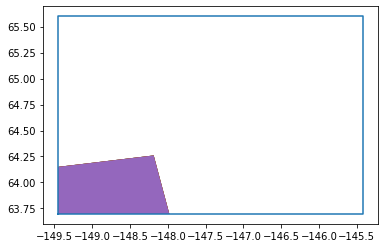

intersections aoi S1B_IW_GRDH_1SDV_20200809T033656_20200809T033721_022841_02B5B0_147A
total_fill type is <class 'shapely.geometry.multipolygon.MultiPolygon'>


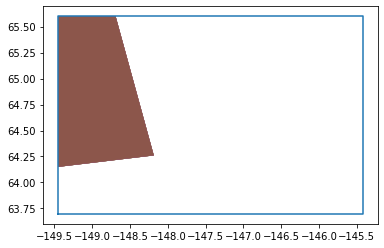

intersections aoi S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21
total_fill type is <class 'shapely.geometry.polygon.Polygon'>


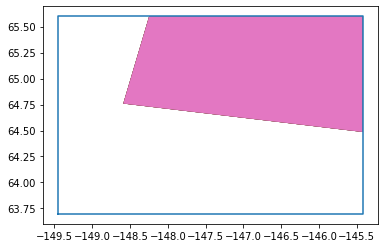

intersections aoi S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635
total_fill type is <class 'shapely.geometry.polygon.Polygon'>


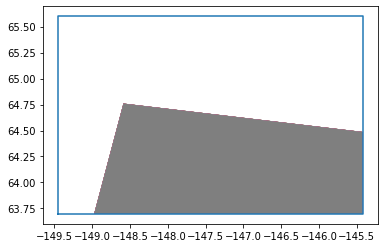

intersections aoi S1B_IW_GRDH_1SDV_20200811T032006_20200811T032031_022870_02B695_B919
total_fill type is <class 'shapely.geometry.polygon.Polygon'>


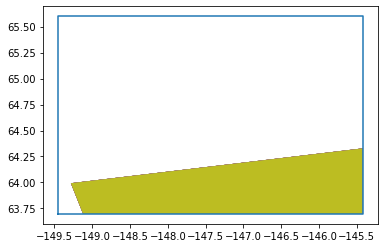

intersections aoi S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8
total_fill type is <class 'shapely.geometry.polygon.Polygon'>


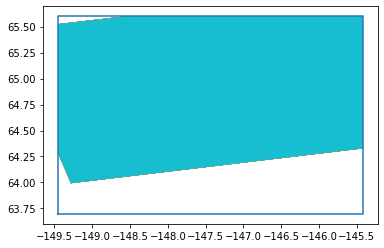

last prod = S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8
S1B_IW_GRDH_1SDV_20200801T030347_20200801T030412_022724_02B20B_927C
S1B_IW_GRDH_1SDV_20200801T030412_20200801T030437_022724_02B20B_0CBB
S1A_IW_GRDH_1SDV_20200807T162818_20200807T162843_033803_03EB45_A6DF
S1A_IW_GRDH_1SDV_20200807T162843_20200807T162908_033803_03EB45_30A8
S1B_IW_GRDH_1SDV_20200809T033631_20200809T033656_022841_02B5B0_6CD7
S1B_IW_GRDH_1SDV_20200809T033656_20200809T033721_022841_02B5B0_147A
S1A_IW_GRDH_1SDV_20200809T161156_20200809T161221_033832_03EC40_9A21
S1A_IW_GRDH_1SDV_20200809T161221_20200809T161246_033832_03EC40_F635
S1B_IW_GRDH_1SDV_20200811T032006_20200811T032031_022870_02B695_B919
S1B_IW_GRDH_1SDV_20200811T032031_20200811T032056_022870_02B695_52D8


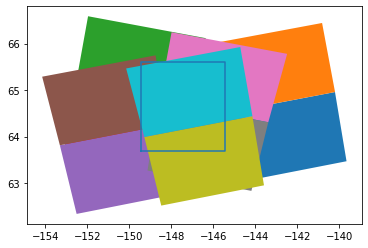

In [125]:
# temp





def test_get_min_granule_coverage(products: list, aoi: Polygon) -> list:
    
    
    min_products = []
    fill_shapes = []
#     fill_shapes.pop(prod.)
#     min_products.append(prod)
    x,y = test_aoi_poly.exterior.xy
    plt.plot(x,y)
    
    for prod in products:
        current_shape = prod.shape
        
        if aoi.intersects(current_shape):
            inter = aoi.intersection(current_shape)
            min_products.append(prod)
            fill_shapes.append(inter)

            print(f"intersections aoi {prod.name}")
        
        total_fill = unary_union(fill_shapes)
        print(f"total_fill type is {type(total_fill)}")
        
        
        
        x,y = test_aoi_poly.exterior.xy
        plt.plot(x,y)
        
        for i in fill_shapes:  
            x,y = inter.exterior.xy
            plt.fill(x,y)
        plt.show()
        
        
        if aoi.equals(total_fill):
            print(f"last prod = {prod.name}")
            return min_products
                
        
    return min_products


sorted_products = triage_products(test_aoi_products)


for p in sorted_products:
    print(p.shape)
    
print("==============")
    
test_miny_prod = test_get_min_granule_coverage(sorted_products, test_aoi_poly)
        
x,y = test_aoi_poly.exterior.xy
plt.plot(x,y)

for p in test_miny_prod:
    x,y = p.shape.exterior.xy
    print(p.name)
    plt.fill(x,y)


#--------------------------------

# fs = sorted_products.pop()
# fs = fs.shape

# inter = fs.intersection(test_aoi_poly)

# fill_shape = Polygon
# intersects=[]
# for p in sorted_products:
#     # shape currnt product
#     s = p.shape
    
#     # intersection of current shape and aoi
#     i = s.intersection(test_aoi_poly)
    
#     intersects.append(i)
    
#     fill_shape = unary_union(intersects)
    
    

    


# u = unary_union(intersects)

# intersects=[]
# fill_shape = Polygon
# while not fill_shape.equals(test_aoi_poly):
#     x = sorted_products.pop()
#     fill_shape = fill_shape.union(x.shape)
#     intersects.append(x)
#     x,y = fill_shape.exterior.xy
#     plt.fill(x,y)
#     plt.show
    

    
    
    
    
    



# x,y=inter.exterior.xy
# plt.fill(x,y)

# x,y=u.exterior.xy
# plt.fill(x,y)



# assert u.equals(test_aoi_poly)

# for p in sorted_products:
#     print(p.name)

    